# CESM 1.12 and 1.04 OHC

In [46]:
import os
import sys
import string
import cmocean
import xesmf as xe
import numpy as np
import xarray as xr
import matplotlib
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [2]:
sys.path.append("..")
%matplotlib inline
matplotlib.rc_file('../rc_file')
# matplotlib.rc_file('../rc_file')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2
%aimport - numpy - scipy - matplotlib.pyplot

In [3]:
from tqdm import notebook
from paths import path_results, path_data, path_prace, path_lc1, path_lpd
from paths import CESM_filename, file_ex_ocn_lc1, file_ex_ocn_ctrl
from filters import lowpass, highpass, bandpass
from regions import boolean_mask
from constants import spy
from OHC_plots import plot_global_integrals, plot_global_integrals_diff, plot_global_integrals_detr
from xr_regression import xr_quadtrend, ocn_field_regression, xr_linear_trend
from ac_derivation_OHC import DeriveOHC as DO
from ab_derivation_SST import DeriveSST as DS
from bb_analysis_timeseries import AnalyzeTimeSeries as ATS

The file "/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f09_g16/spinup_pd_maxcores_f09_g16/run/spinup_pd_maxcores_f09_g16.cam2.h0.0001-01.nc" does not exist


In [4]:
# %%time
# DO().generate_OHC_files(run='hq', year=2040, pwqd=False)
# DO().combine_yrly_OHC_integral_files(run='hq')

In [5]:
OHC_ctrl = xr.open_dataset(f'{path_prace}/OHC/OHC_integrals_ctrl.nc', decode_times=False)
OHC_rcp  = xr.open_dataset(f'{path_prace}/OHC/OHC_integrals_rcp.nc' , decode_times=False)
OHC_lpd  = xr.open_dataset(f'{path_prace}/OHC/OHC_integrals_lpd.nc' , decode_times=False)
OHC_lc1  = xr.open_dataset(f'{path_prace}/OHC/OHC_integrals_lc1.nc' , decode_times=False)
OHC_lr1  = xr.open_dataset(f'{path_prace}/OHC/OHC_integrals_lr1.nc' , decode_times=False)
OHC_hq   = xr.open_dataset(f'{path_prace}/OHC/OHC_integrals_hq.nc'  , decode_times=False).isel(time=np.delete(np.arange(0,50), 39))
OHC_lq   = xr.open_dataset(f'{path_prace}/OHC/OHC_integrals_lq.nc'  , decode_times=False)

In [6]:
da_2400x3600 = OHC_hq.OHC_vertical_0_100m.isel(time=0).rename({'TLAT':'lat','TLONG':'lon'})
da_320x384 = OHC_lq.OHC_vertical_0_100m.isel(time=0).rename({'TLAT':'lat','TLONG':'lon'})
regridder = xe.Regridder(da_2400x3600, da_320x384, 'bilinear', periodic=True, reuse_weights=True)

Reuse existing file: bilinear_2400x3600_384x320_peri.nc


In [7]:
dsh = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)
dsl = xr.open_dataset(file_ex_ocn_lc1, decode_times=False)

## 1. $\Delta$OHC timeseries

(1.9e+25, 3.1e+25)

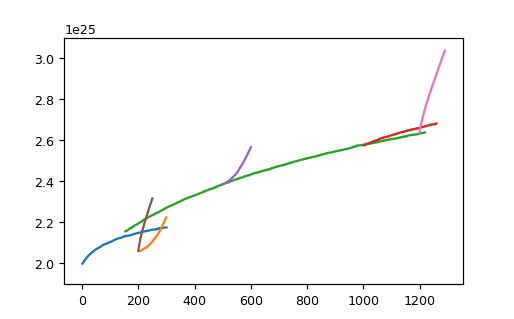

In [13]:
plt.plot(OHC_ctrl.time/365     , OHC_ctrl.OHC_Global_Ocean)
plt.plot(OHC_rcp .time/365-1800, OHC_rcp .OHC_Global_Ocean)
plt.plot(OHC_lpd .time[:-250]/365, OHC_lpd.OHC_Global_Ocean[:-250])
plt.plot(OHC_lc1 .time/365+1000, OHC_lc1 .OHC_Global_Ocean)
plt.plot(OHC_lr1 .time/365-1500, OHC_lr1 .OHC_Global_Ocean)
plt.plot(OHC_hq  .time/365-1800, OHC_hq  .OHC_Global_Ocean)
plt.plot(OHC_lq  .time/365- 800, OHC_lq  .OHC_Global_Ocean)
plt.ylim((1.9e25,3.1e25))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


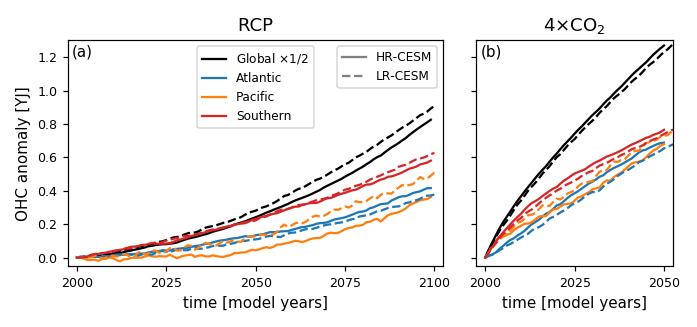

In [14]:
f, ax = plt.subplots(1,2, figsize=(6.4,3), sharey=True, gridspec_kw={'width_ratios':[105,55]})
L1, = ax[0].plot([0,1],[0,1], ls='-' , c='grey', label='HR-CESM')
L2, = ax[0].plot([0,1],[0,1], ls='--', c='grey', label='LR-CESM')
l1, = ax[0].plot(OHC_rcp .time/365, (OHC_rcp.OHC_Global_Ocean-OHC_rcp  .OHC_Global_Ocean  [0])/2e24, c='k' , ls='-', label=r'Global $\times 1/2$')
l2, = ax[0].plot(OHC_rcp .time/365, (OHC_rcp.OHC_Atlantic_Ocean-OHC_rcp.OHC_Atlantic_Ocean[0])/1e24, c='C0', ls='-', label='Atlantic')
l3, = ax[0].plot(OHC_rcp .time/365, (OHC_rcp.OHC_Pacific_Ocean-OHC_rcp .OHC_Pacific_Ocean [0])/1e24, c='C1', ls='-', label='Pacific')
l4, = ax[0].plot(OHC_rcp .time/365, (OHC_rcp.OHC_Southern_Ocean-OHC_rcp.OHC_Southern_Ocean[0])/1e24, c='C3', ls='-', label='Southern')
ax[0].plot(OHC_lr1 .time/365, (OHC_lr1.OHC_Global_Ocean-OHC_lr1  .OHC_Global_Ocean  [0])/2e24, c='k' , ls='--')
ax[0].plot(OHC_lr1 .time/365, (OHC_lr1.OHC_Atlantic_Ocean-OHC_lr1.OHC_Atlantic_Ocean[0])/1e24, c='C0', ls='--')
ax[0].plot(OHC_lr1 .time/365, (OHC_lr1.OHC_Pacific_Ocean-OHC_lr1 .OHC_Pacific_Ocean [0])/1e24, c='C1', ls='--')
ax[0].plot(OHC_lr1 .time/365, (OHC_lr1.OHC_Southern_Ocean-OHC_lr1.OHC_Southern_Ocean[0])/1e24, c='C3', ls='--')

ax[1].plot(OHC_hq .time/365, (OHC_hq.OHC_Global_Ocean-OHC_hq  .OHC_Global_Ocean  [0])/2e24, c='k' , ls='-')
ax[1].plot(OHC_hq .time/365, (OHC_hq.OHC_Atlantic_Ocean-OHC_hq.OHC_Atlantic_Ocean[0])/1e24, c='C0', ls='-')
ax[1].plot(OHC_hq .time/365, (OHC_hq.OHC_Pacific_Ocean-OHC_hq .OHC_Pacific_Ocean [0])/1e24, c='C1', ls='-')
ax[1].plot(OHC_hq .time/365, (OHC_hq.OHC_Southern_Ocean-OHC_hq.OHC_Southern_Ocean[0])/1e24, c='C3', ls='-')
ax[1].plot(OHC_lq .time/365, (OHC_lq.OHC_Global_Ocean-OHC_lq  .OHC_Global_Ocean  [0])/2e24, c='k' , ls='--')
ax[1].plot(OHC_lq .time/365, (OHC_lq.OHC_Atlantic_Ocean-OHC_lq.OHC_Atlantic_Ocean[0])/1e24, c='C0', ls='--')
ax[1].plot(OHC_lq .time/365, (OHC_lq.OHC_Pacific_Ocean-OHC_lq .OHC_Pacific_Ocean [0])/1e24, c='C1', ls='--')
ax[1].plot(OHC_lq .time/365, (OHC_lq.OHC_Southern_Ocean-OHC_lq.OHC_Southern_Ocean[0])/1e24, c='C3', ls='--')

leg1 = ax[0].legend(handles=[l1,l2,l3,l4], loc='upper center', fontsize=8)
ax[0].legend(handles=[L1,L2], loc='upper right', fontsize=8)
# ax[0].legend(handles=[l1,l2,l3,l4,L1,L2], loc='upper right', fontsize=8, ncol=3)
ax[0].add_artist(leg1)
ax[0].set_title('RCP')
ax[1].set_title(r'4$\times$CO$_2$')
ax[0].text(0.01, .93, '(a)', transform=ax[0].transAxes)
ax[1].text(0.02, .93, '(b)', transform=ax[1].transAxes)
ax[0].set_xticks(np.arange(2000,2101,25))
ax[1].set_xticks(np.arange(2000,2051,25))
ax[0].set_xlim((1997.5,2102.5))
ax[1].set_xlim((1997.5,2052.5))
for i in range(2):
    ax[i].set_xlabel('time [model years]')
ax[0].set_ylabel('OHC anomaly [YJ]')
ax[1].set_ylim((-.05,1.3))
plt.tight_layout()
# plt.savefig(f'{path_results}/ECS/OHC_basin_RCP_4xCO2')

plt.savefig(f'{path_results}/thesis/63_OHC_basins')
plt.savefig(f'{path_results}/thesis/63_OHC_basins.eps')

### > add heat flux time series through 100 m, 700 m, and 2000 m.

integrated heat flux map

## 2. $\Delta$OHC with depth

0
1.412651284062456e+22
1
7.410883654138418e+22
0
6.911238668608235e+22
1
1.6405810930014658e+23


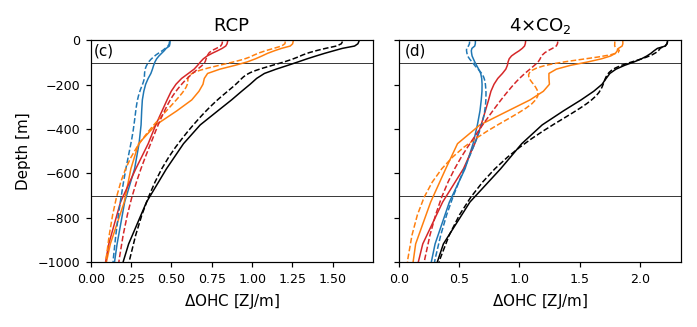

In [8]:
f, axs = plt.subplots(1,2, sharey=True, figsize=(6.4,3))
for i, OHC in enumerate([OHC_rcp, OHC_hq, OHC_lr1, OHC_lq]):
    dz = [dsh.dz,dsl.dz][int(i/2)]/1e2  # [m]
    if i<2:
        axs[i].axvline(0, c='k', lw=.5)
        axs[i].axhline(-100, c='k', lw=.5)
        axs[i].axhline(-700, c='k', lw=.5)
        axs[i].set_title(['RCP',r'4$\times$CO$_2$'][i])
        axs[i].plot([],[],c='grey',ls='-', label='HR-CESM')
        axs[i].plot([],[],c='grey',ls='--',label='LR-CESM')
        axs[i].set_xlabel('$\Delta$OHC [ZJ/m]')
    k = i%2
    k_ = int(i/2)+1
    print(k)
#     ax = axs[k_-1]
    ax = axs[k]
    ls = ['-','-','--','--'][i]
    t = [-1,-1,-2,50][i]
    for j, ocean in enumerate(['Global', 'Atlantic', 'Pacific', 'Southern']):
        f = [.5,1,1,1][j]
        c = ['k','C0','C1','C3'][j]
        dOHC = f*(OHC[f'OHC_levels_{ocean}_Ocean'].isel(time=t) -\
                  OHC[f'OHC_levels_{ocean}_Ocean'].isel(time=0))/1e21# * dz
        if j==0:  label = r'Global $\times 1/2$'
        else:     label = ocean
        ax.plot(dOHC, -OHC.z_t/1e2, c=c, ls=ls, lw=1, label=label)
#         ax.plot(f*(OHC[f'OHC_levels_{ocean}_Ocean'].isel(time=slice(15*k_,20*k_)).mean('time')/dz-OHC[f'OHC_levels_{ocean}_Ocean'].isel(time=0)/dz), -OHC.z_t/1e2, c=c, ls=ls, lw=.5)
    print((OHC[f'OHC_levels_Global_Ocean'].isel(time=slice(45*k_,50*k_)).mean('time')-OHC[f'OHC_levels_Global_Ocean'].isel(time=0)).sum().values)
#     if i==0:
#         ax.legend()
axs[0].set_ylabel('Depth [m]')
for i  in range(2):
    axs[i].set_xlim((0,None))
axs[0].text(0.01, .93, '(c)', transform=axs[0].transAxes)
axs[1].text(0.02, .93, '(d)', transform=axs[1].transAxes)
plt.ylim((-1000,0.01))
plt.tight_layout()
plt.savefig(f'{path_results}/thesis/63_OHC_depth.eps')

## 3. $\Delta$OHC maps

In [10]:
%%time
OHC_ctrl_0_100m  = regridder(OHC_rcp.OHC_vertical_0_100m .isel(time=0))
OHC_ctrl_0_700m  = regridder(OHC_rcp.OHC_vertical_0_700m .isel(time=0))
OHC_ctrl_0_6000m = regridder(OHC_rcp.OHC_vertical_0_6000m.isel(time=0))

OHC_lpd_0_100m   = OHC_lr1.OHC_vertical_0_100m .isel(time=0)
OHC_lpd_0_700m   = OHC_lr1.OHC_vertical_0_700m .isel(time=0)
OHC_lpd_0_6000m  = OHC_lr1.OHC_vertical_0_6000m.isel(time=0)

OHC_lq_0_100m    = 1.5*OHC_lq.OHC_vertical_0_100m .isel(time=0)-0.5*OHC_lq.OHC_vertical_0_100m .isel(time=1)
OHC_lq_0_700m    = 1.5*OHC_lq.OHC_vertical_0_700m .isel(time=0)-0.5*OHC_lq.OHC_vertical_0_700m .isel(time=1)
OHC_lq_0_6000m   = 1.5*OHC_lq.OHC_vertical_0_6000m.isel(time=0)-0.5*OHC_lq.OHC_vertical_0_6000m.isel(time=1)

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


CPU times: user 0 ns, sys: 396 ms, total: 396 ms
Wall time: 1.24 s


In [11]:
X, Y = OHC_lq.TLONG, OHC_lq.TLAT
alphabet = 'abcdefghi'

def map_array_geometry(m,n=3):
    """ calculates the fraction of the """
    width = 8                 # fixed width for now, assuming 3 maps
    height = .22+m*1.32+.6    # .22 for title, m rows of 1.32 maps, and colorbars
    y1 = 1-(.22+1.32)/height  # base height of top-most row of maps
    dy = 1.32/height          # height of maps
    yc = .42/height           # position of colorbar
    dc = .13/height           # height of horizontal colorbar
    return width, height, y1, dy, yc, dc

def comparison_maps(xa_list, kw1, kw2, label1=None, label2=None, fn=None):
    """ makes 2x3 maps comparing HIGH/LOW RCP/4xCO2 runs"""
    width, height, y1, dy, yc, dc = map_array_geometry(m=3)

    f = plt.figure(figsize=(width,height))
    for i, run in enumerate(['HR-CESM','LR-CESM',r'HR-CESM $-$ LR-CESM']):
        for j, depth in enumerate([r'0-100 m  ($\times 5$)', '100-700 m', 'below 700 m']):
            xa = xa_list[j][i]
            ax = f.add_axes([.025+i*.325,y1-j*dy,.32,dy], projection=ccrs.PlateCarree())
            if j==0:  ax.set_title(run)
            if i==0:  ax.text(-.07,.5, depth, transform=ax.transAxes, rotation=90, va='center')
            if i<2:  kw = kw1
            else:    kw = kw2

            im = ax.pcolormesh(X, Y, xa, **kw)
            ax.coastlines(lw=.5)
            ax.text(.01,.9, '('+alphabet[i+j*3]+')', transform=ax.transAxes)
            if i==0 and j==0:
                cax = f.add_axes([.025,yc,.645,dc])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=label1)
            if i==2 and j==0:
                cax = f.add_axes([.675,yc,.32,dc])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=label2, ticks=np.arange(-6,7,3))
            if fn is not None:
                plt.savefig(fn)
    return

In [12]:
kw1 = {'vmin':-15, 'vmax':15, 'cmap':'cmo.balance'}
kw2 = {'vmin':-7.5, 'vmax':7.5, 'cmap':'cmo.curl'}
label = r'$\Delta$OHC  [GJ m$^{-2}$]'

In [13]:
%%time
dOHC_hq_100  = regridder(OHC_hq.OHC_vertical_0_100m .isel(time=-1)) - OHC_ctrl_0_100m
dOHC_hq_700  = regridder(OHC_hq.OHC_vertical_0_700m .isel(time=-1)) - OHC_ctrl_0_700m
dOHC_hq_6000 = regridder(OHC_hq.OHC_vertical_0_6000m.isel(time=-1)) - OHC_ctrl_0_6000m
dOHC_lq_100  = OHC_lq.OHC_vertical_0_100m .isel(time=50) - OHC_lq_0_100m
dOHC_lq_700  = OHC_lq.OHC_vertical_0_700m .isel(time=50) - OHC_lq_0_700m
dOHC_lq_6000 = OHC_lq.OHC_vertical_0_6000m.isel(time=50) - OHC_lq_0_6000m

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


CPU times: user 0 ns, sys: 342 ms, total: 342 ms
Wall time: 700 ms


CPU times: user 23.9 s, sys: 321 ms, total: 24.2 s
Wall time: 24.7 s


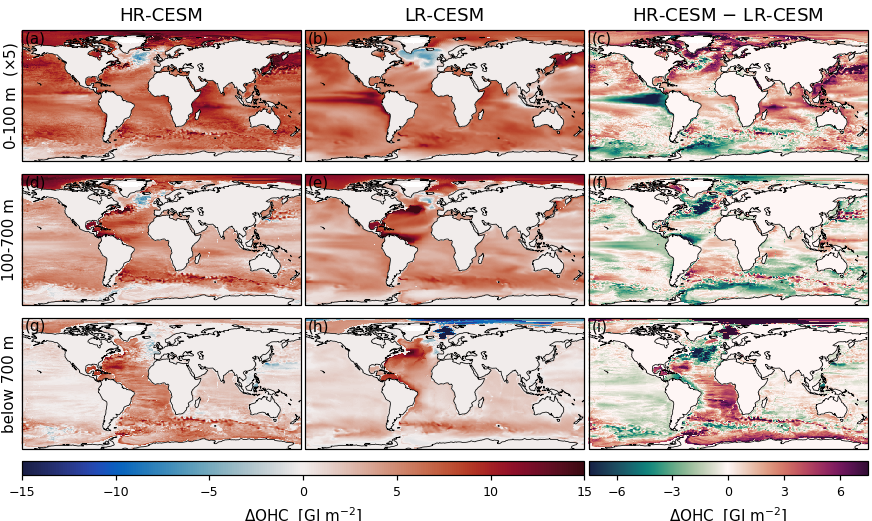

In [20]:
%%time
h1, l1 =  dOHC_hq_100*5            /1e9,  dOHC_lq_100*5            /1e9
h2, l2 = (dOHC_hq_700 -dOHC_hq_100)/1e9, (dOHC_lq_700 -dOHC_lq_100)/1e9
h3, l3 = (dOHC_hq_6000-dOHC_hq_700)/1e9, (dOHC_lq_6000-dOHC_lq_700)/1e9
xa_list = [[h1, l1, h1-l1],
           [h2, l2, h2-l2],
           [h3, l3, h3-l3],]
fn = f'{path_results}/thesis/63_OHC_maps_4xCO2'
comparison_maps(xa_list, kw1, kw2, label1=label, label2=label, fn=fn)

In [15]:
%%time
dOHC_rcp_100  = regridder(OHC_rcp.OHC_vertical_0_100m .isel(time=-1)) - OHC_ctrl_0_100m
dOHC_rcp_700  = regridder(OHC_rcp.OHC_vertical_0_700m .isel(time=-1)) - OHC_ctrl_0_700m
dOHC_rcp_6000 = regridder(OHC_rcp.OHC_vertical_0_6000m.isel(time=-1)) - OHC_ctrl_0_6000m
dOHC_lr1_100  = OHC_lr1.OHC_vertical_0_100m .isel(time=-2) - OHC_lpd_0_100m
dOHC_lr1_700  = OHC_lr1.OHC_vertical_0_700m .isel(time=-2) - OHC_lpd_0_700m
dOHC_lr1_6000 = OHC_lr1.OHC_vertical_0_6000m.isel(time=-2) - OHC_lpd_0_6000m

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


CPU times: user 0 ns, sys: 339 ms, total: 339 ms
Wall time: 654 ms


CPU times: user 23.5 s, sys: 206 ms, total: 23.7 s
Wall time: 24.1 s


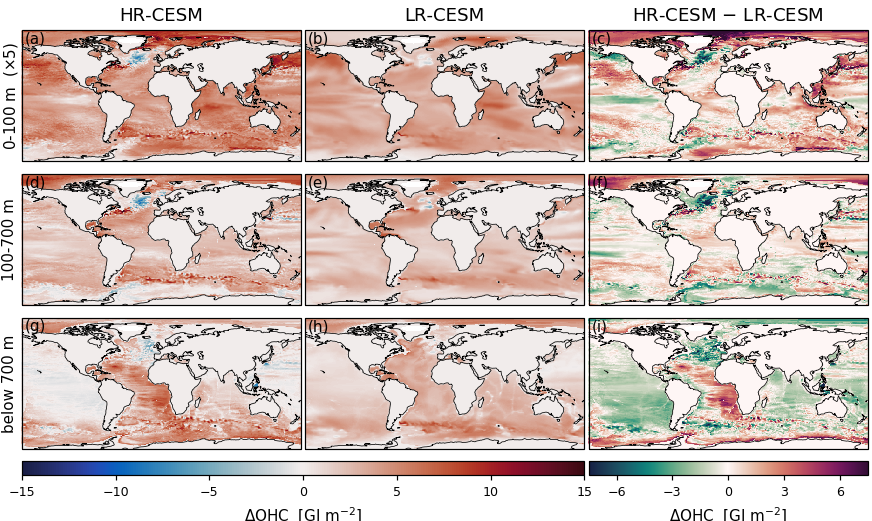

In [22]:
%%time
h1, l1 =  dOHC_rcp_100*5             /1e9,  dOHC_lr1_100*5             /1e9
h2, l2 = (dOHC_rcp_700 -dOHC_rcp_100)/1e9, (dOHC_lr1_700 -dOHC_lr1_100)/1e9
h3, l3 = (dOHC_rcp_6000-dOHC_rcp_700)/1e9, (dOHC_lr1_6000-dOHC_lr1_700)/1e9
xa_list = [[h1, l1, h1-l1],
           [h2, l2, h2-l2],
           [h3, l3, h3-l3],]

fn = f'{path_results}/thesis/63_OHC_maps_rcp'
comparison_maps(xa_list, kw1, kw2, label1=label, label2=label, fn=fn)

## Southpolar projection

In [78]:
c1 = OHC_rcp.OHC_vertical_0_100m .isel(time=0)
c7 = OHC_rcp.OHC_vertical_0_700m .isel(time=0)
r1 = OHC_rcp.OHC_vertical_0_100m .isel(time=-1)
r7 = OHC_rcp.OHC_vertical_0_700m .isel(time=-1)
q1 = OHC_hq.OHC_vertical_0_100m .isel(time=-1)
q7 = OHC_hq.OHC_vertical_0_700m .isel(time=-1)
H2r = (r7-r1) - (c7-c1)
H2q = (q7-q1) - (c7-c1)
H2r = H2r.where(dsh.REGION_MASK>0)
H2q = H2q.where(dsh.REGION_MASK>0)

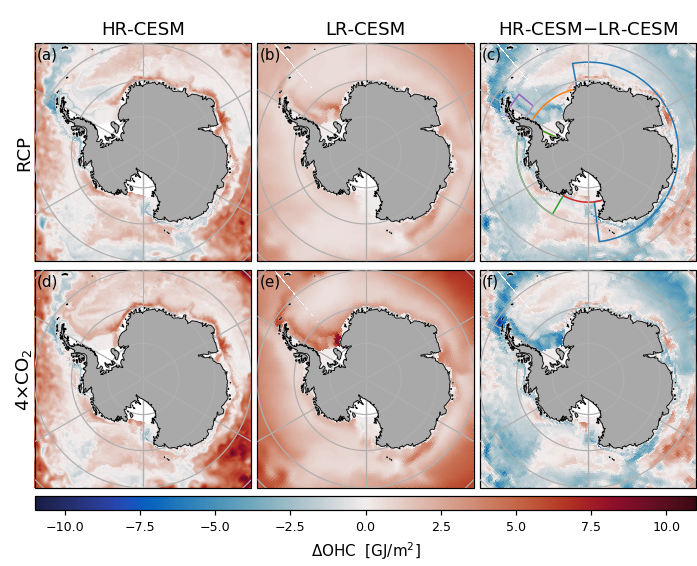

In [82]:
f = plt.figure(figsize=(6.4,5.2))
kw1 = {'vmin':-11, 'vmax':11, 'cmap':'cmo.balance'}

ax00 = f.add_axes([.05 ,.53,.31,.4], projection=ccrs.SouthPolarStereo())
ax01 = f.add_axes([.369,.53,.31,.4], projection=ccrs.SouthPolarStereo())
ax02 = f.add_axes([.688,.53,.31,.4], projection=ccrs.SouthPolarStereo())
ax10 = f.add_axes([.05 ,.13,.31,.4], projection=ccrs.SouthPolarStereo())
ax11 = f.add_axes([.369,.13,.31,.4], projection=ccrs.SouthPolarStereo())
ax12 = f.add_axes([.688,.13,.31,.4], projection=ccrs.SouthPolarStereo())

for i, ax in enumerate([ax00,ax01,ax02]):
    ax.set_title(['HR-CESM','LR-CESM',r'HR-CESM$-$LR-CESM'][i])
for i, ax in enumerate([ax00,ax10]):
    ax.text(-.05,.5,['RCP',r'4$\times$CO$_2$'][i], transform=ax.transAxes, fontsize=12, rotation=90, va='center', ha='center')

    
h2, l2 = (dOHC_rcp_700 -dOHC_rcp_100)/1e9, (dOHC_lr1_700 -dOHC_lr1_100)/1e9
# im = ax00.pcolormesh(h2.lon,h2.lat,h2   , transform=ccrs.PlateCarree(), **kw1)
im = ax00.pcolormesh(H2r.TLONG,H2r.TLAT,H2r/1e9   , transform=ccrs.PlateCarree(), **kw1)
ax01.pcolormesh(h2.lon,h2.lat,l2   , transform=ccrs.PlateCarree(), **kw1)
ax02.pcolormesh(h2.lon,h2.lat,h2-l2, transform=ccrs.PlateCarree(), **kw1)

h2, l2 = (dOHC_hq_700 -dOHC_hq_100)/1e9, (dOHC_lq_700 -dOHC_lq_100)/1e9
# ax10.pcolormesh(h2.lon,h2.lat,h2   , transform=ccrs.PlateCarree(), **kw1)
ax10.pcolormesh(H2q.TLONG,H2q.TLAT,H2q/1e9   , transform=ccrs.PlateCarree(), **kw1)
ax11.pcolormesh(h2.lon,h2.lat,l2   , transform=ccrs.PlateCarree(), **kw1)
ax12.pcolormesh(h2.lon,h2.lat,h2-l2, transform=ccrs.PlateCarree(), **kw1)


cax1 = f.add_axes([.05,.099,.688+.31-.05,.025])
plt.colorbar(im, cax=cax1, orientation='horizontal', label=r'$\Delta$OHC  [GJ/m$^2$]')

for i, ax in enumerate([ax00, ax01, ax02, ax10, ax11, ax12]):
    
    ax.set_extent([-180,360,-90,-60], crs=ccrs.PlateCarree())
    
for i, r in enumerate([rEAIS_, rWedd, rAmun, rRoss, rPen1, rPen2]):
    rect = rect_polygon((r[2],r[3],r[0],r[1]))
    ax02.add_patch(mpatches.Polygon(xy=rect,
                                      facecolor='none', edgecolor=f'C{i}',
                                      linewidth=1, zorder=2,
                                      transform=ccrs.PlateCarree(), ), )

for i, ax in enumerate([ax00, ax01, ax02, ax10, ax11, ax12]):
    ax.add_feature(cartopy.feature.LAND, fc='darkgrey', zorder=3)
    ax.coastlines(lw=.5,zorder=4)
    ax.gridlines(zorder=4)
    ax.text(0.01,0.93, f'({"abcdef"[i]})', transform=ax.transAxes, zorder=5)
    
plt.savefig(f'{path_results}/thesis/65_SO_warming')

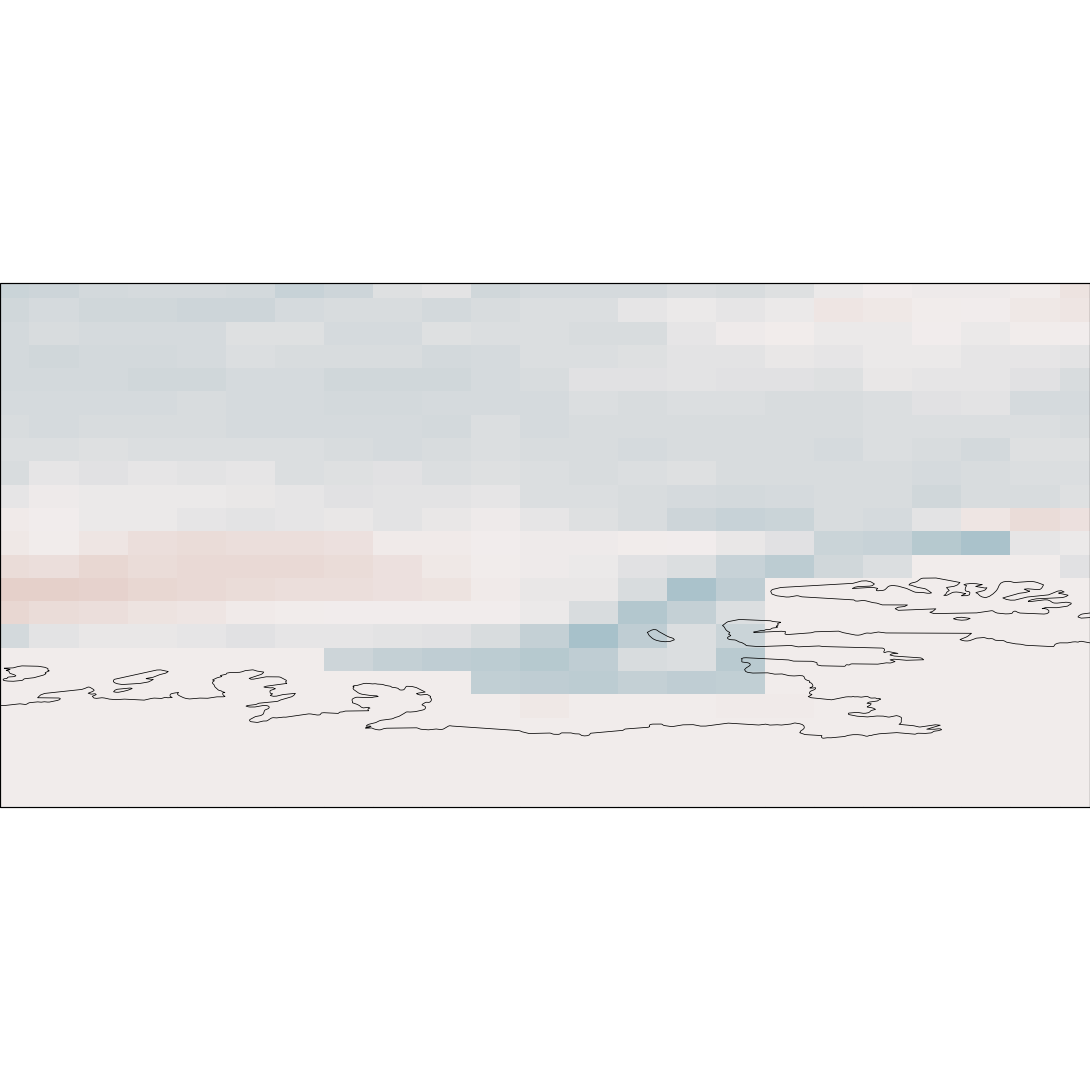

In [75]:
f = plt.figure(figsize=(10,10))
# ax = f.add_axes([0,0,1,1], projection=ccrs.SouthPolarStereo())
ax = f.add_axes([0,0,1,1], projection=ccrs.PlateCarree())
ax.pcolormesh(h2.lon,h2.lat,h2-l2, transform=ccrs.PlateCarree(), **kw1)
ax.set_extent([-120,-95,-77,-65], crs=ccrs.PlateCarree())
ax.coastlines(lw=.5,zorder=4)


In [23]:
ds = xr.open_dataset(file_ex_ocn_lc1, decode_times=False).TEMP

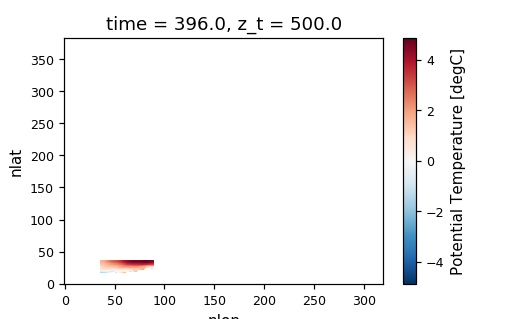

In [25]:
ds[0,0,:,:].where(ds.TLAT<-60).where(ds.TLONG>0).where(ds.TLONG<60).plot()

In [49]:
rEAIS = [-76,-65,350,173,369]
rEAIS_ = [-76,-65,-10,173,369]
rWedd = [-90,-72,295,350,429]
rAmun = [-90,-70,210,295,305]
rRoss = [-90,-76,150,210,312]
rPen1 = [-70,-65,294,310,420]
rPen2 = [-75,-70,285,295,420]

In [33]:
from maps import rect_polygon
from xr_DataArrays import xr_DZ

In [34]:
DZT = xr_DZ('ocn_low')

[[285.         -75.        ]
 [285.20408163 -75.        ]
 [285.40816327 -75.        ]
 [285.6122449  -75.        ]
 [285.81632653 -75.        ]
 [286.02040816 -75.        ]
 [286.2244898  -75.        ]
 [286.42857143 -75.        ]
 [286.63265306 -75.        ]
 [286.83673469 -75.        ]
 [287.04081633 -75.        ]
 [287.24489796 -75.        ]
 [287.44897959 -75.        ]
 [287.65306122 -75.        ]
 [287.85714286 -75.        ]
 [288.06122449 -75.        ]
 [288.26530612 -75.        ]
 [288.46938776 -75.        ]
 [288.67346939 -75.        ]
 [288.87755102 -75.        ]
 [289.08163265 -75.        ]
 [289.28571429 -75.        ]
 [289.48979592 -75.        ]
 [289.69387755 -75.        ]
 [289.89795918 -75.        ]
 [290.10204082 -75.        ]
 [290.30612245 -75.        ]
 [290.51020408 -75.        ]
 [290.71428571 -75.        ]
 [290.91836735 -75.        ]
 [291.12244898 -75.        ]
 [291.32653061 -75.        ]
 [291.53061224 -75.        ]
 [291.73469388 -75.        ]
 [291.93877551

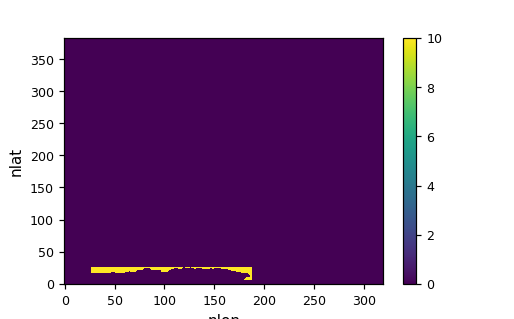

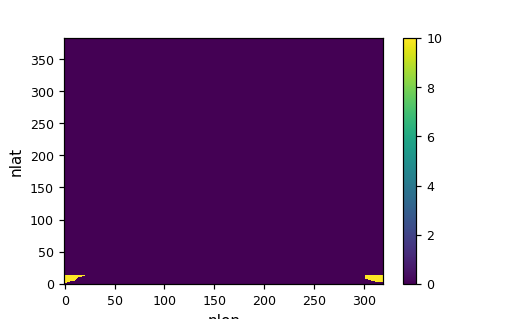

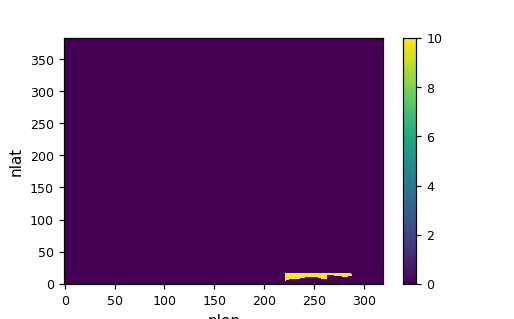

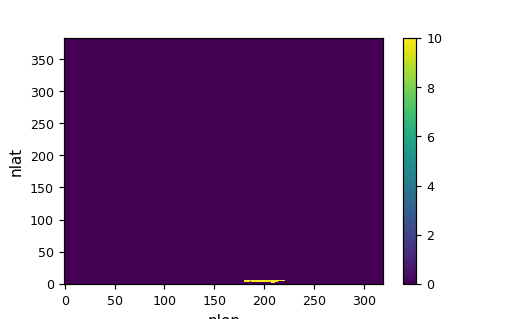

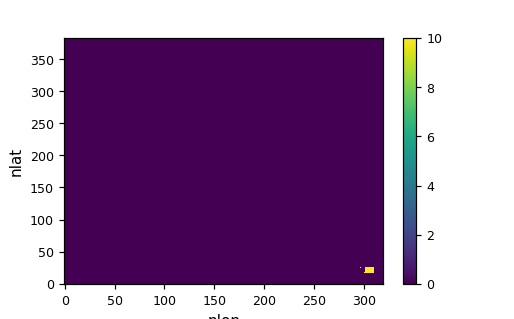

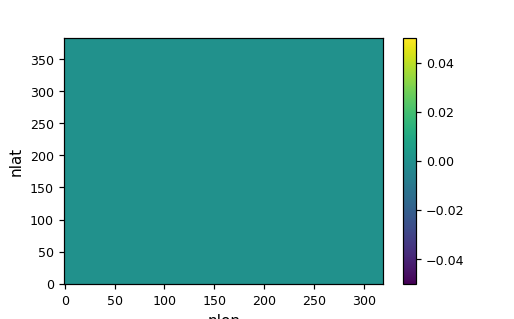

In [43]:
for i, r in enumerate([rEAIS, rWedd, rAmun, rRoss, rPen1, rPen2]):
    rp = rect_polygon((r[2],r[3],r[0],r[1]))
    if i==5: print(rp)
    V = DZT.where(ds.TLAT>r[0]).where(ds.TLAT<r[1])
    if r[2]>r[3]:
        V = V.where(ds.TLONG>r[2]).fillna(0)+V.where(ds.TLONG<r[3]).fillna(0)
    else:
        V = V.where(ds.TLONG>r[2]).where(ds.TLONG<r[3]).fillna(0)
    plt.figure()
    V[0,:,:].plot()

In [24]:
def map_array_geometry(m,n=3):
    """ calculates the fraction of the """
    width = 8                 # fixed width for now, assuming 3 maps
    dx = .29                   # width of image [fraction]
    dy_ = dx*width/1.9        # height of maps [in], aspect ratio is 1:2, but choose smaller value to create vertical space
    print(dy_)
    height = .22 + m*dy_      # .22 for title, m rows of 1.32 maps [in]
    dy = dy_/height           # height of maps [fraction]
    y1 = 1-(.22+dy_)/height   # base height of top-most row of maps
    xc = (width-.65)/width    # x-position of colorbar
    dc = .13/width            # width of vertical colorbar
    return width, height, y1, dx, dy, xc, dc

letters = 'abcdefghi'
width, height, y1, dx, dy, xc, dc = map_array_geometry(m=3, n=3)
print(width, height, y1, dx, dy, xc, dc)

f = plt.figure(figsize=(width,height))
for i in range(3):  # columns
    for j in range(m):  # rows
        print(i, j, .025+i*(dx+.005),y1-j*dy,dx,dy)
        ax = f.add_axes([.025+i*(dx+.005),y1-j*dy,dx,dy], projection=ccrs.PlateCarree())
        ax.coastlines(lw=.5)
        ax.text(.01,.9, '('+letters[i+j*3]+')', transform=ax.transAxes)
        if j==0:
            ax.set_title('HIGH')
        if i==0:
            ax.text(-.065,.5, 'RCP', transform=ax.transAxes, rotation=90, va='center')
        if i==2 and j==2:
            cax = f.add_axes([xc+.005,y1-j*dy,dc,dy])
            cax = f.add_axes([xc+.005,y1-j*dy,dc,dy])
plt.colorbar(im, cax=cax, orientation='vertical', label='something something')

1.2210526315789474
8 3.883157894736842 0.628896719978314 0.29 0.31444835998915693 0.91875 0.01625


NameError: name 'm' is not defined

<Figure size 872x423.264 with 0 Axes>

In [ ]:
def comparison_maps(xa_list, kw1, kw2, label1=None, label2=None, fn=None):
    """ makes 2x3 maps comparing HIGH/LOW RCP/4xCO2 runs"""
    width, height, y1, dy, yc, dc = map_array_geometry(m=2)

    f = plt.figure(figsize=(width,height))
    for i, run in enumerate(['HIGH','LOW','HIGH-LOW']):
        for j, scenario in enumerate(['RCP', '4xCO2']):
            xa = xa_list[j][i]
            ax = f.add_axes([.025+i*.325,y1-j*dy,.32,dy], projection=ccrs.PlateCarree())
            if j==0:  ax.set_title(run)
            if i==0:  ax.text(-.07,.5, scenario, transform=ax.transAxes, rotation=90, va='center')
            # ax.set_ylabel(scenario)
            if i<2:  kw = kw1
            else:    kw = kw2

            im = ax.pcolormesh(X, Y, xa, **kw)
            ax.text(.01,.9, '('+letters[i+j*3]+')', transform=ax.transAxes)#,  weight='bold')# backgroundcolor='lightgrey',)
            # if i==0 and j==0:
            #     cax = f.add_axes([.025,yc,.645,dc])
            #     plt.colorbar(im, cax=cax, orientation='horizontal', label=label1)
            # if i==2 and j==0:
            #     cax = f.add_axes([.675,yc,.32,dc])
            #     plt.colorbar(im, cax=cax, orientation='horizontal', label=label2)
            # if fn is not None:
                plt.savefig(fn)
    return

In [ ]:
OHC_rcp

In [ ]:
(ocn_field_regression(OHC_lq.OHC_vertical_0_6000m, run='lpd')[0]*365*100).plot()